<a href="https://colab.research.google.com/github/Colsai/shirabayashi_data606/blob/main/data_preparation_eda/Initial_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OIG Workplan & Reports EDA
An Exploratory Analysis of Current HHS OIG Workplan and Reports data.   
Notes on the scraping and methodology can be found in the project folder. 

## Objectives:
- Explore and Visualize the Initial Data for the *Workplan_df* and its connected *Reports_df*
- Create Word Clouds Based on some initial text cleaning

In [33]:
#For Cleaner Notebook Display
from IPython.display import clear_output

In [34]:
#Install Packages
!pip install sweetviz

clear_output()

In [35]:
#Import Packages
import sweetviz as sv
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem import RegexpStemmer
from wordcloud import WordCloud, STOPWORDS

nltk.download(['punkt', 
               'stopwords'])

clear_output()

### Load DataFrames from Scraped Sources
- Workplan_df: The OIG Work Plan, a list and summaries of work that OIG is (or has) undertaken.
- Reports_df: All scraped, connected reports to any listed work plan items.

In [36]:
###########################
# Load CSVs (Github)      #
###########################
workplan_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_workplan_summaries.csv?raw=true")

#Drop typo column
workplan_df.drop(columns = 'Office of Evaluation and Inspections', 
                 inplace = True)

reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

#Drop dead column
reports_df.drop(columns = 'Unnamed: 0',
                inplace = True)

In [93]:
#Print Basic Stats for Both Dataframes:
print(f"{workplan_df.info()}{reports_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Announced or Revised      659 non-null    object
 1   Agency                    659 non-null    object
 2   Title                     659 non-null    object
 3   Component                 658 non-null    object
 4   Report Number(s)          659 non-null    object
 5   Expected Issue Date (FY)  656 non-null    object
 6   Website_Link              659 non-null    object
 7   Summary                   659 non-null    object
 8   summary_tokenized         659 non-null    object
 9   summary_token_num         659 non-null    int64 
 10  summary_unique_token      659 non-null    int64 
dtypes: int64(2), object(9)
memory usage: 56.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 3 columns):
 #   Column            Non-Null Count 

### Determine Stopwords
- Use the same set of stopwords for both the work plan and reports for text cleaning. 

In [37]:
#Determine Stopwords
stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (asp and amp were relics of links within the page)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',])

#Extend for more subject-based words
stopwords.extend([
                  'oig',
                  'hhs',
                  'amp',
                  'asp'])


## EDA: Work Plan Data
- The OIG workplan is a tabular re-creation of all of the current (and former) ongoing HHS OIG work from FY2018 on.

### OIG Work Plans
- Work Plans are general overviews of the scope of the project that OIG is looking to undertake.

In [38]:
workplan_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Announced or Revised      659 non-null    object
 1   Agency                    659 non-null    object
 2   Title                     659 non-null    object
 3   Component                 658 non-null    object
 4   Report Number(s)          659 non-null    object
 5   Expected Issue Date (FY)  656 non-null    object
 6   Website_Link              659 non-null    object
 7   Summary                   659 non-null    object
dtypes: object(8)
memory usage: 41.3+ KB


In [39]:
#What are the statuses of all items?
workplan_df['Announced or Revised'].value_counts()[0:10]

Completed              266
Revised                115
Completed (partial)     70
Nov-16                  29
Removed                 28
November 2021           11
February 2022           10
June 2021                8
December 2021            7
January 2022             6
Name: Announced or Revised, dtype: int64

In [40]:
#Opdiv/Staffdiv (Top-10)
workplan_df['Agency'].value_counts()[0:10]

Centers for Medicare & Medicaid Services        293
Centers for Medicare and Medicaid Services      122
Administration for Children and Families         46
National Institutes of Health                    26
Food and Drug Administration                     20
Centers for Disease Control and Prevention       18
Indian Health Service                            15
Other                                            14
OS                                               14
Health Resources and Services Administration     13
Name: Agency, dtype: int64

In [41]:
#Are Any Products Listed Multiple Times? (Top-10)
workplan_titles = workplan_df.Title.value_counts().reset_index()

workplan_titles.columns = ['Summary_Title', 
                           'Count']

workplan_titles[workplan_titles['Count'] > 1]

,Summary_Title,Count
0,Ensuring Dual-Eligible Beneficiaries' Access t...,5
1,Superfund Financial Activities at the National...,3
2,Mandatory Review of HHS Agencies' Annual Accou...,2
3,OIG Oversight of State Medicaid Fraud Control ...,2
4,Audit of the Department of Health and Human Se...,2
5,Comparison of Average Sales Prices and Average...,2
6,Audit of Administration for Community Living's...,2
7,State Medicaid Fraud Control Units FY 2017 Ann...,2
8,HHS Compliance with the Improper Payment Elimi...,2
9,Meeting the Challenges Presented by COVID-19: ...,2


In [42]:
#Check through EID (expected issue date)
workplan_df['Expected Issue Date (FY)'].value_counts()

2022                        214
2020                         90
2023                         85
2021                         74
2019                         63
2018                         62
2017                         27
Not Applicable               19
Annual                        3
2024                          3
2017, 2018                    2
FY 2021                       2
11-12-2021                    1
7/8/2021                      1
Every 6 months                1
Triennially                   1
2018, 2019                    1
11-18-2021                    1
Completed 2017                1
2019, 2020                    1
7/7/2021                      1
8/6/2021                      1
Completed (partial) 2017      1
10/18/2021                    1
Name: Expected Issue Date (FY), dtype: int64

In [43]:
#Check workplans by year (ignore all non-standardized years)
mask = [True if len(str(workplan)) == 4 else False 
        for workplan in workplan_df['Expected Issue Date (FY)']]

print("Expected Issue Date (FY) Year Values:")
workplan_df[mask]['Expected Issue Date (FY)'].value_counts()

Expected Issue Date (FY) Year Values:


2022    214
2020     90
2023     85
2021     74
2019     63
2018     62
2017     27
2024      3
Name: Expected Issue Date (FY), dtype: int64

In [44]:
workplan_df.Component.value_counts()

Office of Audit Services                                             423
Office of Evaluation and Inspections                                 232
Office of Evaluation and Inspection                                    2
Office of Audit Services and Office of Evaluation and Inspections      1
Name: Component, dtype: int64

*OK- our data is kind of a mess. This has to do with some historical issues that need to be resolved with the data.*

In [45]:
#One of them has both?
workplan_df[workplan_df.Component == 'Office of Audit Services and Office of Evaluation and Inspections']

,Announced or Revised,Agency,Title,Component,Report Number(s),Expected Issue Date (FY),Website_Link,Summary
35,Nov-16,Centers for Medicare & Medicaid Services,Medicaid Payment Suspensions for Credible Alle...,Office of Audit Services and Office of Evaluat...,OEI-09-14-00020,2017,https://oig.hhs.gov/reports-and-publications/w...,Federal financial participation in Medicaid is...


In [46]:
#Highest-Represented Agencies
workplan_df.Agency.value_counts()[0:5]

Centers for Medicare & Medicaid Services      293
Centers for Medicare and Medicaid Services    122
Administration for Children and Families       46
National Institutes of Health                  26
Food and Drug Administration                   20
Name: Agency, dtype: int64

In [48]:
#Print Columns and Nulls
_ = [print(idx, col, f"{workplan_df[col].isna().sum()/len(workplan_df)}") for
     idx, col in enumerate(workplan_df.columns)]

0 Announced or Revised 0.0
1 Agency 0.0
2 Title 0.0
3 Component 0.0015174506828528073
4 Report Number(s) 0.0
5 Expected Issue Date (FY) 0.004552352048558422
6 Website_Link 0.0
7 Summary 0.0


In [50]:
###########################
# Tokenize                #
###########################
#Set tokenizer as regex tokenizer to remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in workplan_df["Summary"]]

tokenized_sums = [[i for i in tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
workplan_df["summary_tokenized"] = tokenized_stemmed_sums

workplan_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

#Set of unique tokens
workplan_df["summary_unique_token"] = [len(set(sum_tok)) for sum_tok in workplan_df["summary_tokenized"]]

<Figure size 1080x576 with 0 Axes>

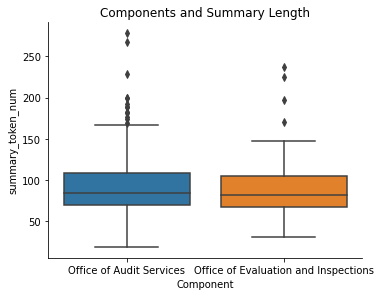

In [51]:
mask = [True if comp in ["Office of Audit Services", "Office of Evaluation and Inspections"] 
        else False for comp in workplan_df["Component"]]

plt.figure(figsize = (15,8))

sns.catplot(x="Component", 
            y="summary_token_num", 
            kind="box", 
            data=workplan_df[mask],
            height = 4,
            aspect = 12/9).set(title ="Components and Summary Length")

In [52]:
#How many unique tokens do we have from our list of work plan summaries?
len(set(workplan_df["summary_tokenized"].apply(pd.Series).stack().unique()))

4335

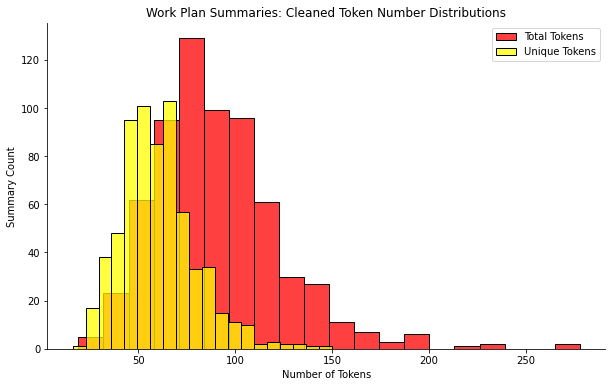

In [53]:
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6), sharex = True, sharey = True)

sns.histplot(data=workplan_df, 
             x="summary_token_num", 
             bins = 20,
             color = 'red',
             alpha = .75,
             label = 'Total Tokens')

sns.histplot(data=workplan_df, 
             x="summary_unique_token", 
             bins = 20,
             color = 'yellow',
             alpha = .75,
             label = 'Unique Tokens')

#Style Plot
sns.despine()
ax.set_title("Work Plan Summaries: Cleaned Token Number Distributions")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Summary Count")
ax.legend()

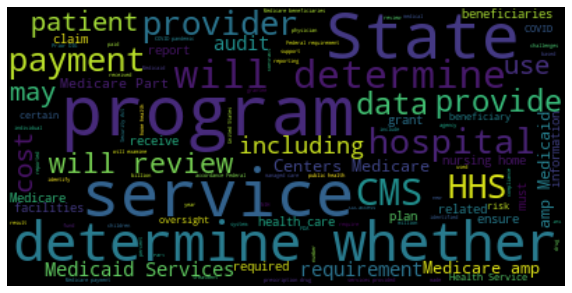

In [87]:
#########################
# Workplan: Word Cloud  #
#########################

#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6))

# Start with one review:
text = str([''.join(word) for word in workplan_df["Summary"]])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## OIG Reports
- Reports are summaries of the specific findings and recommendations that OIG discovers after the work on a specific project has been completed. They include details on the project scope, as well as recommendations found from the project itself. 

In [54]:
reports_df.head()

,Report Number(s),Workplan_Title,Workplan_Summary
0,A-02-17-02005,New York Did Not Have Adequate Oversight of It...,The Temporary Assistance for Needy Families (T...
1,A-02-16-02009,The Administration for Children and Families R...,The Administration for Children and Families (...
2,A-09-16-01004,The Administration for Children and Families R...,Head Start grantees are required to have Singl...
3,A-06-17-07003,The Administration for Children and Families D...,Head Start grantees are required to have Singl...
4,A-02-16-02013,"The Children's Village, Inc., an Administratio...",The Office of Refugee Resettlement (ORR) withi...


In [55]:
reports_df['Workplan_Summary'] = reports_df['Workplan_Summary'].fillna(' ')

In [56]:
reports_df['Workplan_Summary'] 

0      The Temporary Assistance for Needy Families (T...
1      The Administration for Children and Families (...
2      Head Start grantees are required to have Singl...
3      Head Start grantees are required to have Singl...
4      The Office of Refugee Resettlement (ORR) withi...
                             ...                        
732                                                     
733    In Vermont, child support services are provide...
734                                                     
735                                                     
736                                                     
Name: Workplan_Summary, Length: 737, dtype: object

In [57]:
#Subset out any workplan product with no title
reports_clean_df = reports_df[reports_df['Workplan_Title'].notna()]

In [58]:
###########################
# Tokenize                #
###########################
#Set tokenizer as regex tokenizer to remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in reports_clean_df["Workplan_Summary"]]

tokenized_sums = [[i for i in tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
reports_clean_df["summary_tokenized"] = tokenized_stemmed_sums

#Number of tokens after cleaning data
reports_clean_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

#Set of unique tokens
reports_clean_df["summary_unique_token"] = [len(set(sum_tok)) for sum_tok in reports_clean_df["summary_tokenized"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [59]:
#How many unique tokens do we have from the reports data?
#https://stackoverflow.com/questions/38895856/how-to-compile-all-lists-in-a-column-into-one-unique-list
print("Total Tokens:")
len(set(reports_clean_df["summary_tokenized"].apply(pd.Series).stack().unique()))

Total Tokens:


5780

In [60]:
def word_stats(df):
    try:
        total_tokens = df["summary_token_num"].sum()
        
    except Exception as e:
        print(e)

    try:
        unique_tokens = (len(set(df["summary_tokenized"].apply(pd.Series).stack().unique())))

    except Exception as e:
        print(e)

    return [total_tokens, unique_tokens]

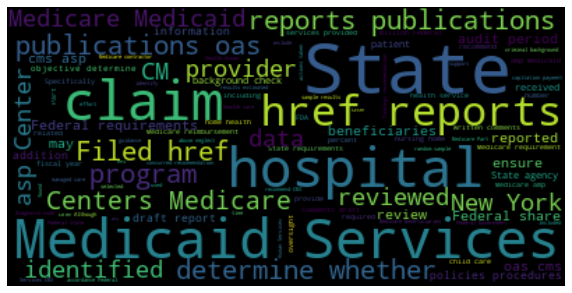

In [91]:
#########################
# Reports: Word Cloud   #
#########################
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6))

# Start with one review:
text = str([''.join(word) for word in reports_df["Workplan_Summary"]])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

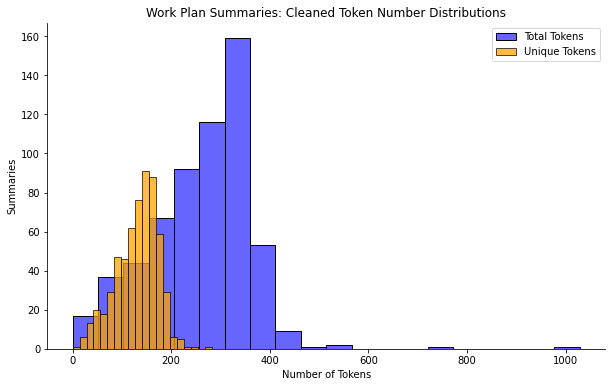

In [63]:
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6), 
                       sharex = True, 
                       sharey = True)

sns.histplot(data=reports_clean_df, 
             x="summary_token_num", 
             bins = 20,
             color = 'blue',
             alpha = .6,
             label = 'Total Tokens')

sns.histplot(data=reports_clean_df, 
             x="summary_unique_token", 
             bins = 20,
             color = 'orange',
             alpha = .75,
             label = 'Unique Tokens')

#Style Plot
sns.despine()
ax.set_title("Work Plan Summaries: Cleaned Token Number Distributions")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Summaries")
ax.legend()

## Exploratory Data Analysis 
*Deeper look at the current data fields*

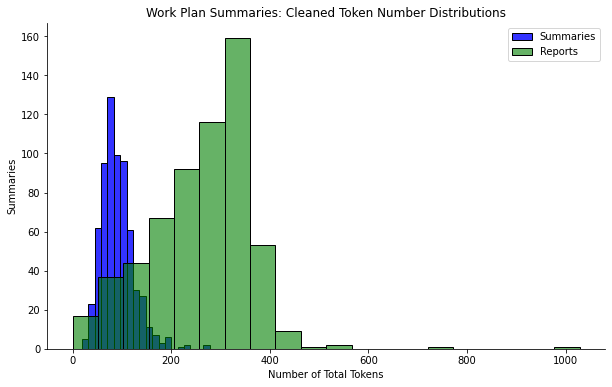

In [64]:
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6), sharex = True)

#Comparing the number of tokens 
sns.histplot(data=workplan_df, 
             x="summary_token_num", 
             bins = 20,
             color = 'blue',
             alpha = .8,
             label = 'Summaries',
             ax = ax)

sns.histplot(data=reports_clean_df, 
             x="summary_token_num", 
             bins = 20,
             ax = ax,
             color = 'green',
             alpha = .6,
             label = 'Reports')

#Style Plot
sns.despine()
ax.set_title("Work Plan Summaries: Cleaned Token Number Distributions")
ax.set_xlabel("Number of Total Tokens")
ax.set_ylabel("Summaries")
ax.legend()

## Create Sweetviz Initial Exploration: